# 6. Klasteryzacja, agregacja i autokorelacja danych

In [1]:
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import os
os.environ["OMP_NUM_THREADS"] = '1'
from sklearn.cluster import KMeans
sns.set()
sns.set_theme(style="whitegrid")

### Przygotowanie danych

In [2]:
points_1 = pd.read_csv(".\Data\points_1.csv")
points_2 = pd.read_csv(".\Data\points_2.csv")
points_3 = pd.read_csv(".\Data\points_3.csv")

### Klasteryzacja metodą k-średnich

Przygotowano funkcję `k_means_elbow_curve_test()`, która będzie wykonywała klasteryzację danych dla ustalonego zakresu liczby klastrów oraz obliczała dane niezbędne do wykreślenia wykresu typu elbow curve, na podstawie którego można podjąć decyzję na temat optymalnej liczby klastrów.

Wartość parametru `inertias` przedstawia sume kwadratu odległości punktów od centrum klastra. Obliczana jest według wzoru: <br/>
$ Inertia  = {\sum_i \underset {\mu_j\in C} {\textrm{min}} (||\chi_{ij} - \mu_j||^2)}$ <br/>

 
Wykorzystano przygotowaną funkcję do podzielenia na optymalną liczbę klastrów rozkładu punktów z pliku points_1.csv. 

#### a) Przygotowanie funkcji

In [3]:
def k_means_elbow_curve_test(points, number_of_clusters):
    """
    Parameters
    -------
    points: DataFrame
        Tablica zawierająca dwie kolumny ze współrzędnymi punktów opisane jako "X" i "Y".
    number_of_clusters: list
        Lista określająca zakres testowanej liczby klastrów.
        Przykład: [1, 5]   

 

    Returns
    -------
    clusters: DataFrame
        Tablica zbierająca wyniki klasteryzacji w następujących kolumnach:
        - "X" - współrzędne X punktów,
        - "Y" - współrzedne Y punktów,
        - kolejne kolumny (ich liczba zależy od liczby testowanych liczebności klastrów) opisane są jako liczba klastrów,
        np. "1", "2", itd. i zawierają numery klastrów, do których zostały przyporządkowane konkretne punkty.
    elbow_curve: DataFrame
        Tablica zbierająca dane niebędne do wykonania wykresu elbow curve w dwóch kolumnach:
        - "N" - liczba klastrów,
        - "D(N)" - suma kwadratu odległości punktów od centrum klastra, do którego jest przypisany.
    """

    points_list = list(zip(points["X"], points["Y"]))

    inertias = []
    N = []


    for i in range(number_of_clusters[0],number_of_clusters[1]+1):
        kmeans = KMeans(n_clusters=i)
        kmeans.fit(points_list)
        cluster_indexes = kmeans.labels_
        centers = kmeans.cluster_centers_ 
        inertias.append(kmeans.inertia_)
        N.append(i)
    
    elbow_curve = pd.DataFrame(data = {"N": N, "D(N)": inertias})


    kmeans = KMeans(n_clusters=4)
    kmeans.fit(points_list)
    cluster_indexes = kmeans.labels_


    clusters = pd.DataFrame(data = {"X": points["X"], "Y": points["Y"], "CI": cluster_indexes})

    return(clusters, elbow_curve)

#### b) Wygenerowanie danych

In [4]:
points1_clusters, points1_elbow_curve = k_means_elbow_curve_test(points_1, [1,10])

#### c) Wizualizacja

(0.0, 10.0)

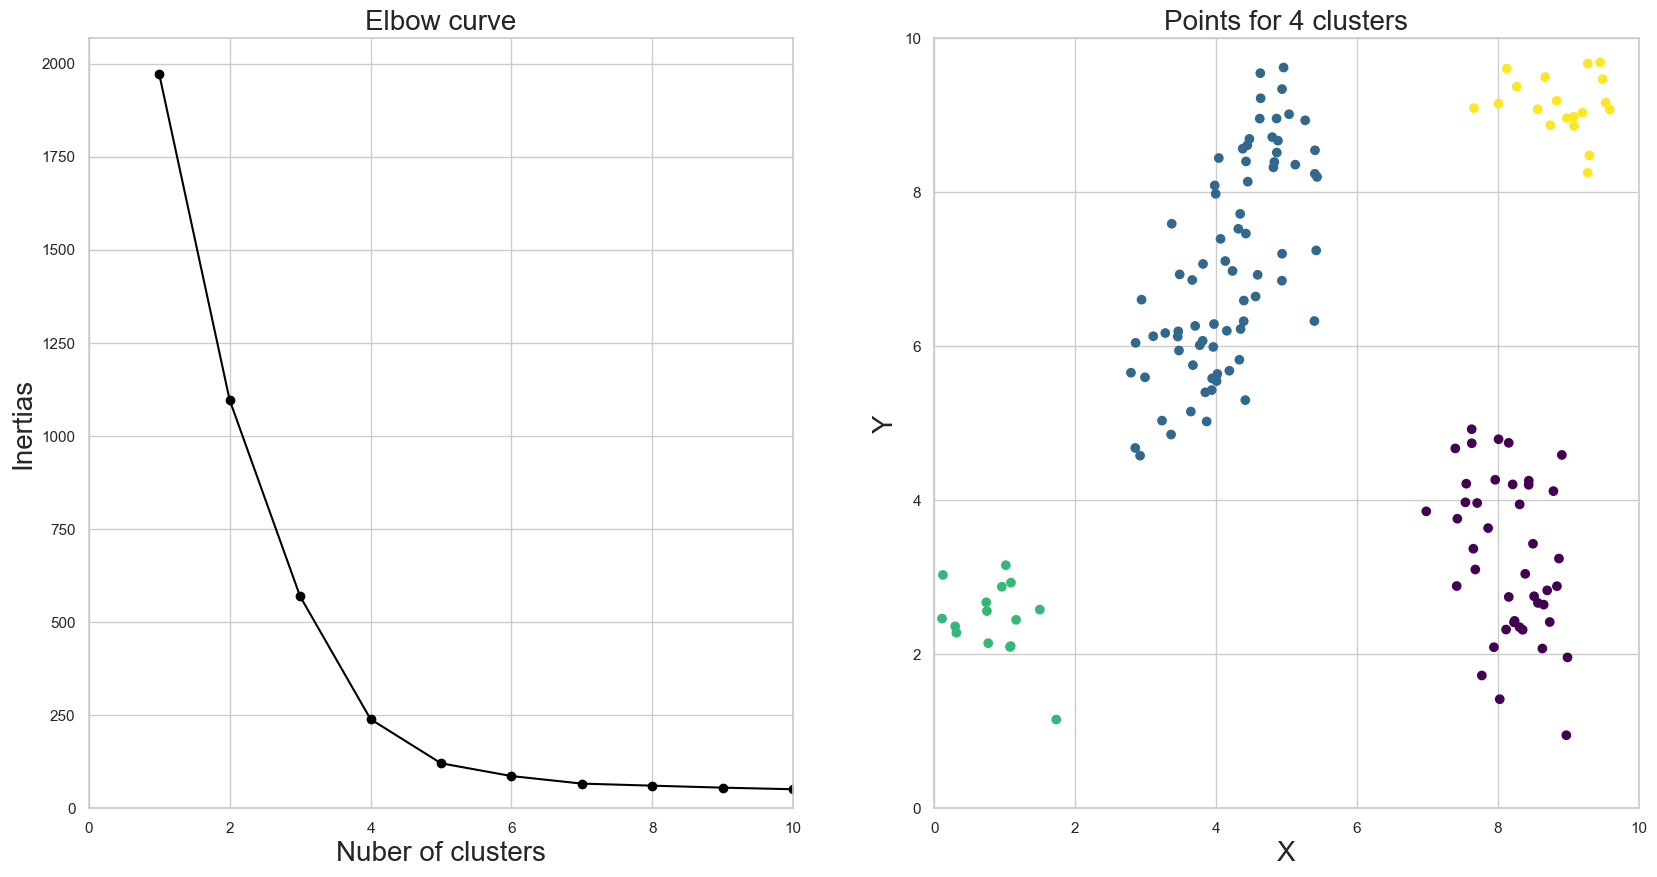

In [5]:
fig, axs = plt.subplots(1,2, figsize = (20,10))


axs[0].plot(points1_elbow_curve["N"], points1_elbow_curve["D(N)"], marker = "o", c="black")
axs[0].set_title("Elbow curve", fontsize=20)
axs[0].set_ylabel("Inertias", fontsize="20")
axs[0].set_xlabel("Nuber of clusters", fontsize="20")
axs[0].set_xlim(0,10)
axs[0].set_ylim(0)

axs[1].scatter(points1_clusters["X"], points1_clusters["Y"], c = points1_clusters["CI"], cmap="viridis")
axs[1].set_title("Points for 4 clusters", fontsize=20)
axs[1].set_ylabel("Y", fontsize="20")
axs[1].set_xlabel("X", fontsize="20")
axs[1].set_xlim(0,10)
axs[1].set_ylim(0,10)

### Agregacja danych na siatce prostokątnej

Przygotowano funkcję `agregate_on_rectangles()`, która będzie zliczać punkty w obrębie prostokątnych podobszarów.

Następnie wykorzystano przygotowaną funkcję do zagregowania rozkładów punktów z plików points_2.csv i points_3.csv. Ustawiono podział obszaru na 40 podobszarów wzdłuż osi $x$ i 20 podobszarów wzdłuż osi $y$.

#### a) Przygotowanie funkcji

In [6]:
def agregate_on_rectangles(points, bins, x_lim, y_lim):
    """
    Parameters
    -------
    points: DataFrame
        Tablica zawierająca dwie kolumny ze współrzędnymi punktów opisane jako "X" i "Y".
    bins: list
        Lista określająca liczbę podobszarów w poziomie i pionie.
        Przykład: [10, 10]
    x_lim: list
        Lista określająca zakres wartości współrzędnej X.
        Przykład: [0, 10]
    y_lim: list
        Lista określająca zakres wartości współrzędnej Y.
        Przykład: [0, 10]   

    Returns
    -------
    binned_data: list
        Lista zawierająca trzy macierze:
        - 1D ze współrzędnymi krawędzi podobszarów na osi X,
        - 1D ze współrzędnymi krawędzi podobszarów na osi Y,
        - 2D z liczbą punków przypisanych do każdego z podobszarów.
        Na przykład: [array([0, 1, 2]), array([0, 1, 2]), array([[7, 2], [4, 5]])]
    """
   
    hist = np.histogram2d(points["X"],points["Y"], bins, range = [x_lim,y_lim])
    hist = list(hist)
    hist[0] = hist[0].T

    return(hist)

#### b) Wygenerowanie danych

In [7]:
points_2_hist = agregate_on_rectangles(points_2, (40,20), [min(points_2["X"]), max(points_2["X"])], [min(points_2["Y"]), max(points_2["Y"])])
points_3_hist = agregate_on_rectangles(points_3, (40,20), [min(points_3["X"]), max(points_3["X"])], [min(points_3["Y"]), max(points_3["Y"])])

#### c) Wizualizacja

(0.0, 10.0)

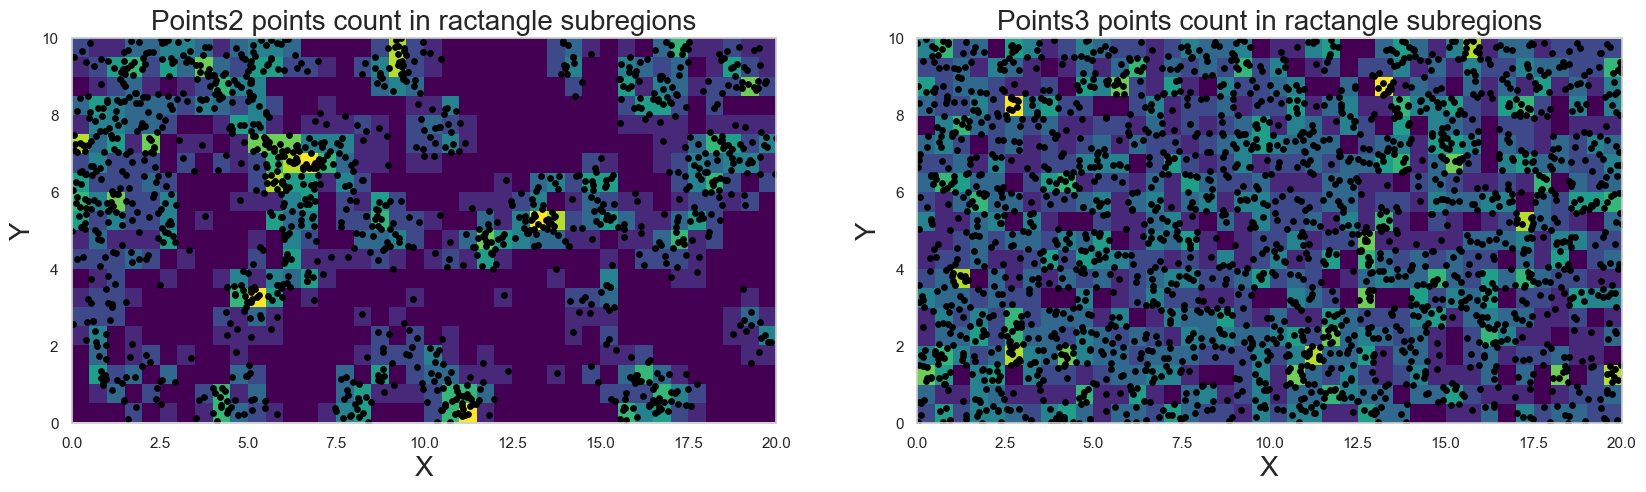

In [8]:
fig,axs = plt.subplots(1,2, figsize = (20,5))


axs[0].pcolormesh(points_2_hist[1],points_2_hist[2],points_2_hist[0],cmap = 'viridis')
axs[0].scatter(points_2["X"], points_2["Y"], c="black", s=15)
axs[0].set_title('Points2 points count in ractangle subregions', fontsize=20)
axs[0].set_xlabel("X", fontsize=20)
axs[0].set_ylabel("Y", fontsize=20)
axs[0].set_xlim(0,20)
axs[0].set_ylim(0,10)

axs[1].pcolormesh(points_3_hist[1],points_3_hist[2],points_3_hist[0],cmap = 'viridis')
axs[1].scatter(points_3["X"], points_3["Y"], c="black", s=15)
axs[1].set_title('Points3 points count in ractangle subregions', fontsize=20)
axs[1].set_xlabel("X", fontsize=20)
axs[1].set_ylabel("Y", fontsize=20)
axs[1].set_xlim(0,20)
axs[1].set_ylim(0,10)

### Tablica sąsiedztwa

Przygotowano funkcję `spatial_weights()`, która będzie przygotowywać tablicę sąsiedztwa podobszarów.

W przypadku gdy zagregowane dane są prostokątnymi tablicami, to tablica sąsiedztwa będzie składała się z 4 przekątnych których układ zależny jest tylko od współrzędnej `x`

Schemat generowania tablicy sąsiedztwa:

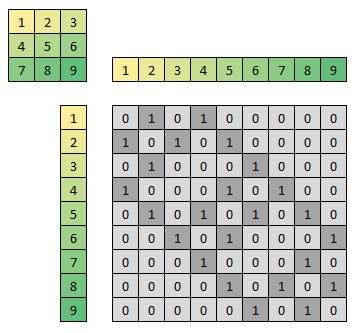

Następnie wykorzystano przygotowaną funkcję do wykonania tablic sąsiedztwa zagregowanych danych.

#### a) Przygotowanie funkcji

In [9]:
def spatial_weights(bin_counts):
    """
    Parameters
    -------
    bin_counts: array
        Macierz 2D z liczbą punków przypisanych do każdego z podobszarów.

    Returns
    -------
    w: array
        Macierz 2D zawierająca wagi przestrzenne.
    """    

    y = len(bin_counts)
    x = len(bin_counts[0])
    
    
    w = np.zeros((x*y,x*y))
    
    for i in range((x*y) - 1):
        
        if((i+1)%x != 0):
            
            w[i][i+1] = 1 
            w[i+1][i] = 1
            
        if(i <= ((x*y)-x-1)):
            
            w[i][i+x] = 1
            w[i+x][i] = 1
    
    return(w)

#### b) Wygenerowanie danych

In [10]:
points_2_neighbours = spatial_weights(points_2_hist[0])
points_3_neighbours = spatial_weights(points_3_hist[0])

#### c) Wizualizacja

Text(0.5, 1.0, 'Neighbours array Points 3')

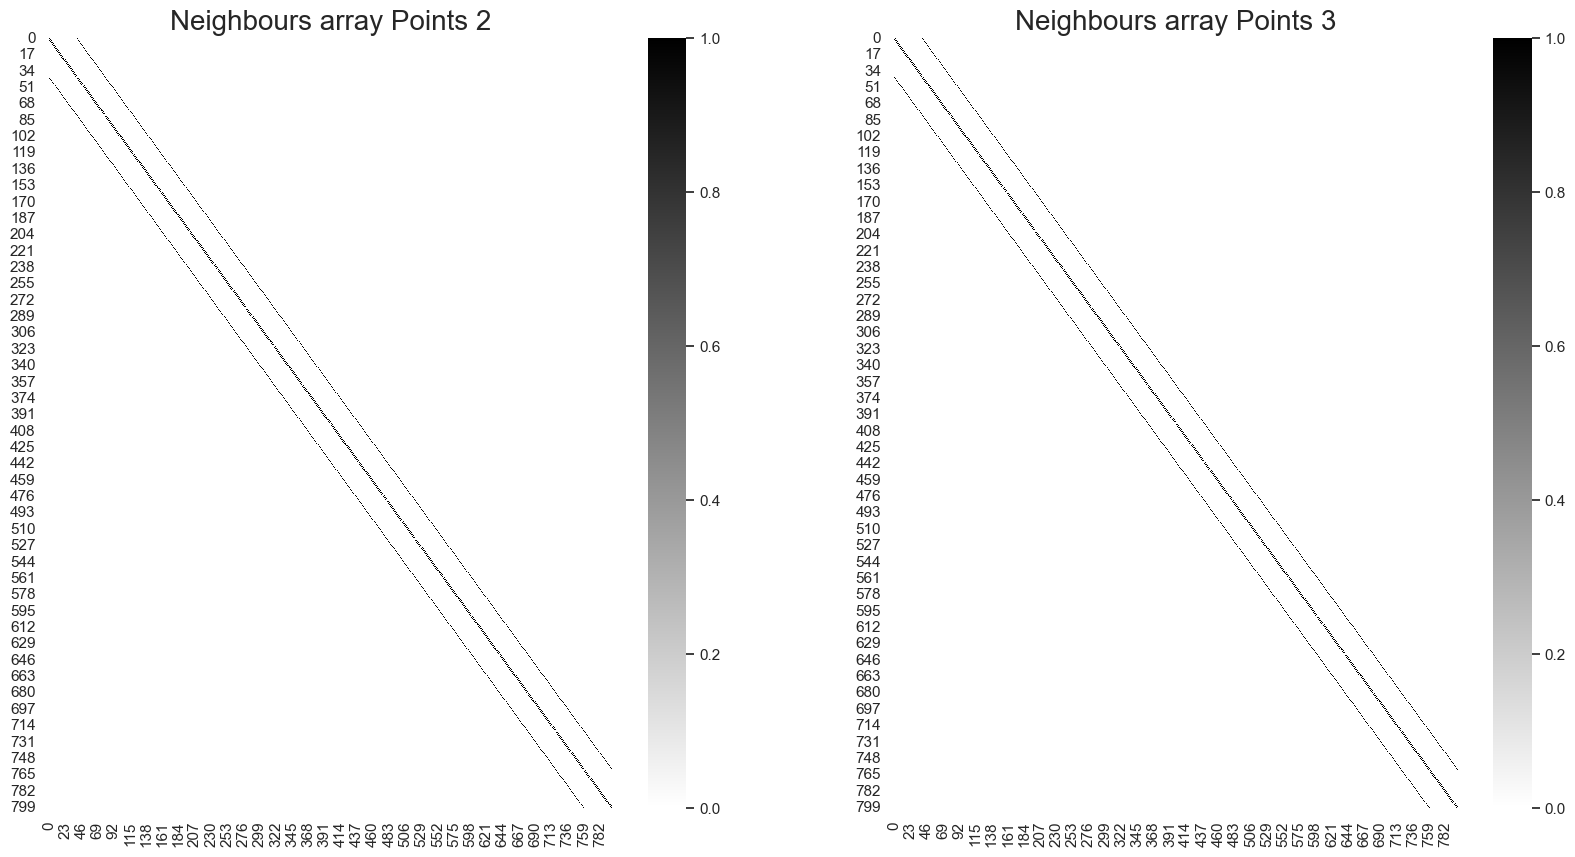

In [11]:
fig,axs = plt.subplots(1,2, figsize=(20,10))

sns.heatmap(points_2_neighbours, ax = axs[0], cmap = "gray_r")
axs[0].set_title("Neighbours array Points 2", fontsize = 20)

sns.heatmap(points_3_neighbours, ax = axs[1], cmap = "gray_r")
axs[1].set_title("Neighbours array Points 3", fontsize = 20)

### Opóźnienie przestrzenne

Przygotowano funkcję `spatial_lag()`, która będzie przygotowywać tablicę wartości opóźnienia przestrzennego.

Następnie wykorzystano przygotowaną funkcję do wyznaczania tablic opóźnienia przestrzennego zagregowanych danych.

Algorytm postępowania:
1) Spłaszczenie macierzy zliczeń w podobszarach.
2) Obliczenie poszczególnych wartości tablicy opóźnienia przestrzennego zgodnie ze wzorem: <br/>
$ LC_{i} = \frac {\sum_j w_{ij} \cdot X_j} {\sum_j w_{ij}}$  <br/>
gdzie: $w$ - macierz sąsiedztwa, $X$ - spłaszczona macierz zliczeń w podobszarach. 
3) Konwersja tablicy opóźnienia przestrzennego do tych samych wymiarów jakie miała wejściowa macierz zliczeń w podobszarach.

#### a) Przygotowanie funkcji

In [12]:
def spatial_lag(binned_data):
    """
    Parameters
    -------
    binned_data: list
        Lista zawierająca trzy macierze:
        - 1D ze współrzędnymi krawędzi podobszarów na osi X,
        - 1D ze współrzędnymi krawędzi podobszarów na osi Y,
        - 2D z liczbą punków przypisanych do każdego z podobszarów.
        Na przykład: [array([0, 1, 2]), array([0, 1, 2]), array([[7, 2], [4, 5]])]

    Returns
    -------
    lagged_data: list
        Lista zawierająca trzy macierze:
        - 1D ze współrzędnymi krawędzi podobszarów na osi X,
        - 1D ze współrzędnymi krawędzi podobszarów na osi Y,
        - 2D z wyliczonymi wartościami opóźnienia przestrzennego.
        Na przykład: [array([0, 1, 2]), array([0, 1, 2]), array([[7, 2], [4, 5]])]
    """       
    
    w = spatial_weights(binned_data[0])
    
    X = binned_data[0].flatten()
    
    LC = np.zeros_like(binned_data[0])
    
    
    k = 0
    for i in range(len(binned_data[0])):
        for j in range(len(binned_data[0][0])):
            sum_l = 0
            sum_m = np.sum(w[k])
            
            for l in range(len(X)):
                sum_l = sum_l + w[k][l]*X[l]
                
            k = k + 1
              
            LC[i][j] = sum_l/sum_m
            
    lagged_data = ((LC), (binned_data[1]), (binned_data[2]))

    
    return(lagged_data)  

#### b) Wygenerowanie danych

In [13]:
points_2_spatial_lag = spatial_lag(points_2_hist)
points_3_spatial_lag = spatial_lag(points_3_hist)

#### c) Wizualizacja

(0.0, 10.0)

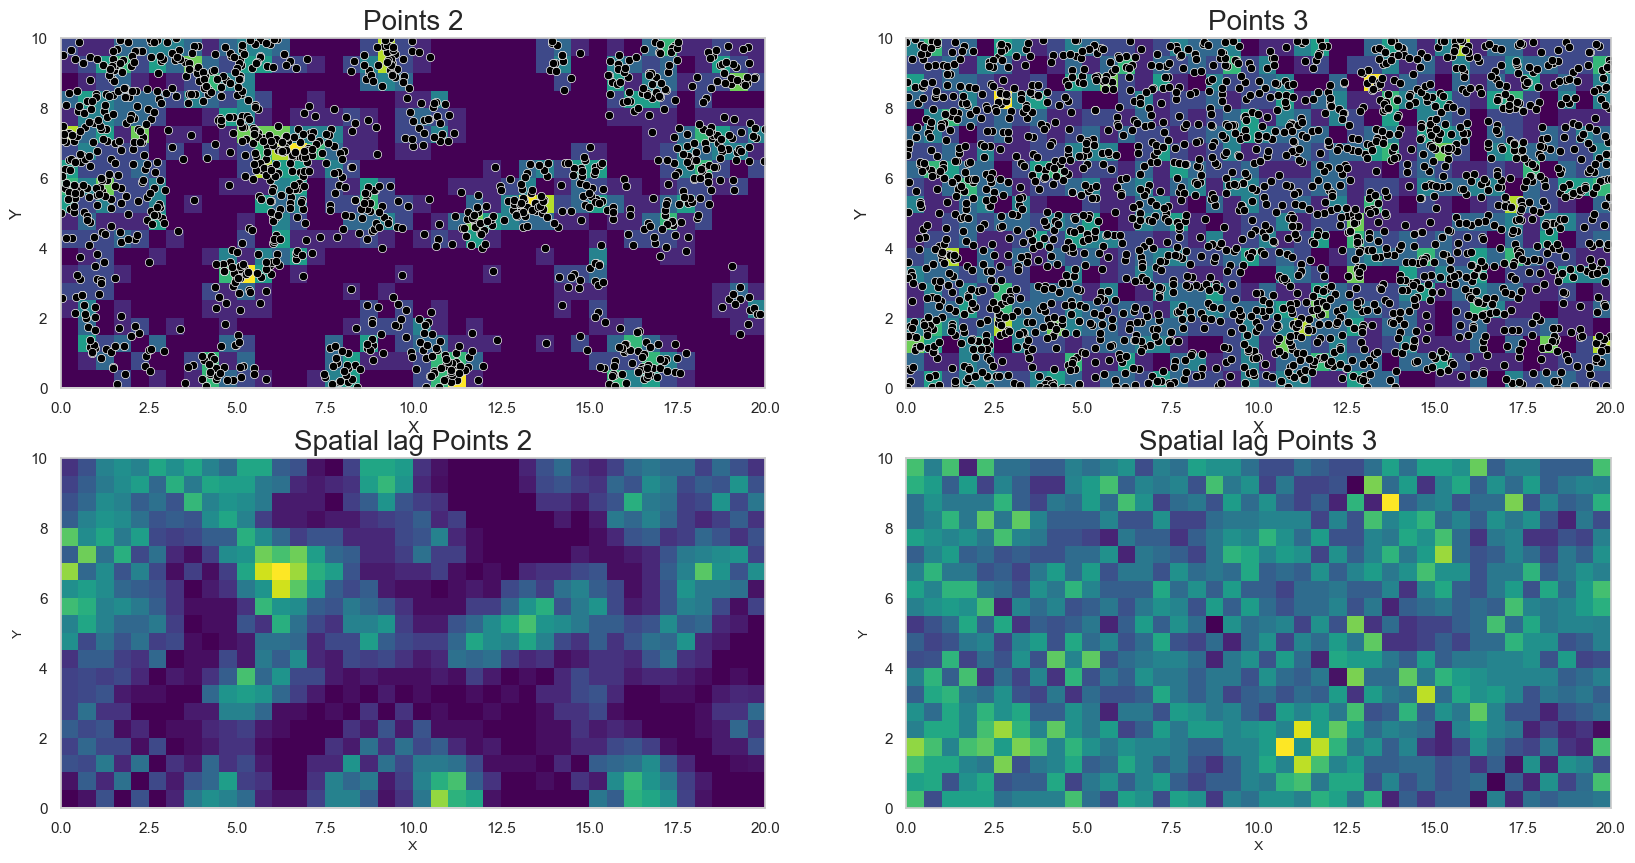

In [14]:
fig, axs = plt.subplots(2,2, figsize=(20,10))


axs[0,0].pcolormesh(points_2_hist[1],points_2_hist[2],points_2_hist[0],cmap = 'viridis')
sns.scatterplot(data = points_2, x = "X",y = "Y", ax = axs[0,0],color = "Black")
axs[0, 0].set_title('Points 2', fontsize=20)
axs[0,0].set_xlim(0,20)
axs[0,0].set_ylim(0,10)

axs[1,0].pcolormesh(points_2_spatial_lag[1],points_2_spatial_lag[2],points_2_spatial_lag[0],cmap = 'viridis')
axs[1,0].set_title("Spatial lag Points 2", fontsize=20)
axs[1,0].set_ylabel("Y", fontsize = 10)
axs[1,0].set_xlabel("X", fontsize = 10)
axs[1,0].set_xlim(0,20)
axs[1,0].set_ylim(0,10)

axs[0,1].pcolormesh(points_3_hist[1],points_3_hist[2],points_3_hist[0],cmap = 'viridis')
sns.scatterplot(data = points_3, x = "X",y = "Y", ax = axs[0,1],color = "Black")
axs[0, 1].set_title('Points 3', fontsize=20)
axs[0,1].set_xlim(0,20)
axs[0,1].set_ylim(0,10)

axs[1,1].pcolormesh(points_3_spatial_lag[1],points_3_spatial_lag[2],points_3_spatial_lag[0],cmap = 'viridis')
axs[1,1].set_title("Spatial lag Points 3", fontsize=20)
axs[1,1].set_ylabel("Y", fontsize = 10)
axs[1,1].set_xlabel("X", fontsize = 10)
axs[1,1].set_xlim(0,20)
axs[1,1].set_ylim(0,10)

### Wykres Morana

Przygotowano funckję `moran_plot_data()`, która będzie przygotowywać dane niezbędne do wykonania wykresu Morana. Wykres Morana to zestawienie wartości z macierzy zliczeń ustandaryzowanych poprzez odjęcie od nich ich wartości średniej (oś x) z wartościami z macierzy opóźnienia przestrzennego ustandaryzowanych poprzez odjęcie od nich ich wartości średniej (oś y) z nałożoną na nie prostą regresji.

Następnie wykorzystano przygotowaną funkcję do przygotowanie danych do wykonania wykresu Morana zagregowanych danych. 

#### a) Przygotowanie funkcji

In [15]:
def moran_plot_data(bin_counts, lagged_counts):
    """
    Parameters
    -------
    bin_counts: array
        Macierz 2D z liczbą punków przypisanych do każdego z podobszarów.
    lagged_counts: array
        Macierz 2D z wartościami opóźnienia przestrzennego przypisanego do każdego z podobszarów.

    Returns
    -------
    moran_plot_data: DataFrame
        Tablica zawierająca dwie kolumny danych niebędnych do wykonania wykresu Morana:
        - "AG_STD" - ustandarywowane dane zagregowane,
        - "SL_STD" - ustandarywzowane wartości opóźnienia przestrzennego.
    """ 
    
    counts = bin_counts.flatten()
    lag = lagged_counts.flatten()
    
    counts_avg = sum(counts)/len(counts)
    lag_avg = sum(lag)/len(lag)
    
    AG_STD = counts - counts_avg
    SL_STD = lag - lag_avg
    
    Df = pd.DataFrame(data = {"AG_STD": AG_STD, "SL_STD": SL_STD})
    
    return(Df)

#### b) Wygenerowanie danych

In [16]:
morana_data2 = moran_plot_data(points_2_hist[0],points_2_spatial_lag[0])
morana_data3 = moran_plot_data(points_3_hist[0],points_3_spatial_lag[0])

#### c) Wizualizacja

Text(0.5, 1.0, 'Points3 Moran')

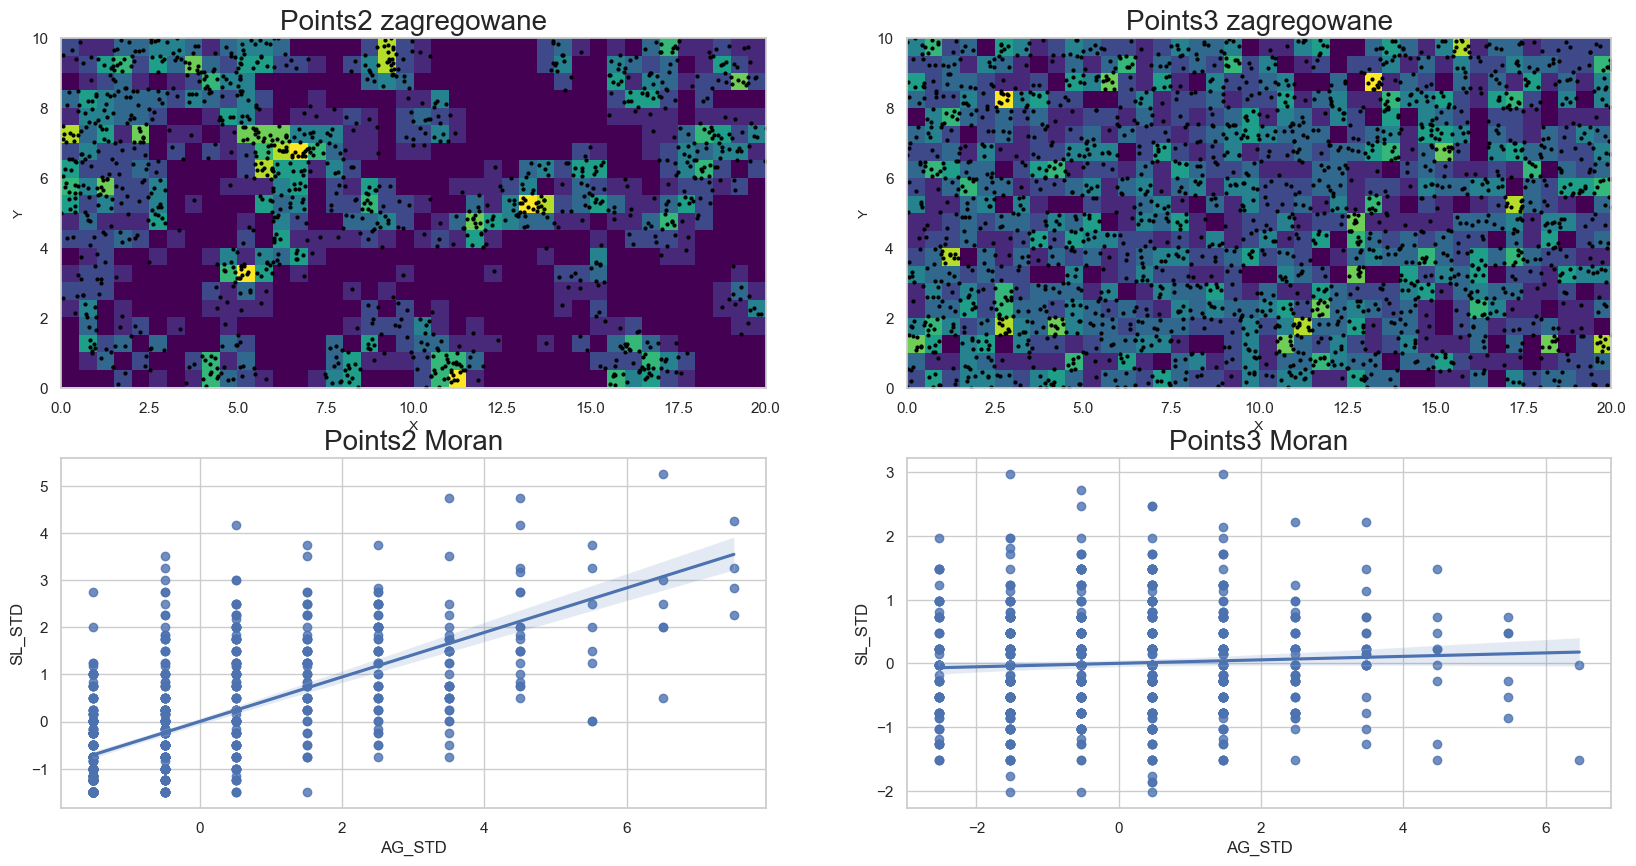

In [17]:
fig, axs = plt.subplots(2,2, figsize = (20,10))


axs[0,0].pcolormesh(points_2_hist[1],points_2_hist[2],points_2_hist[0], cmap = "viridis")
axs[0,0].scatter(points_2["X"], points_2["Y"], s=4, c="black")
axs[0,0].set_xlim(0,20)
axs[0,0].set_ylim(0,10)
axs[0,0].set_title("Points2 zagregowane", fontsize=20)
axs[0,0].set_xlabel("X", fontsize=10)
axs[0,0].set_ylabel("Y", fontsize=10)

sns.regplot(data = morana_data2, x="AG_STD", y="SL_STD", ax=axs[1,0])
axs[1,0].set_title("Points2 Moran", fontsize=20)


axs[0,1].pcolormesh(points_3_hist[1],points_3_hist[2],points_3_hist[0], cmap = "viridis")
axs[0,1].scatter(points_3["X"], points_3["Y"], s=4, c="black")
axs[0,1].set_xlim(0,20)
axs[0,1].set_ylim(0,10)
axs[0,1].set_xlabel("X", fontsize=10)
axs[0,1].set_ylabel("Y", fontsize=10)
axs[0,1].set_title("Points3 zagregowane", fontsize=20)

sns.regplot(data = morana_data3, x="AG_STD", y="SL_STD", ax=axs[1,1])
axs[1,1].set_title("Points3 Moran", fontsize=20)